In [1]:
import numpy as np
from sigKernel import SigKernel, sig_kernel, covariance_test
from multi_sigKernel import *
import time
from tools import *
import pandas as pd
from tqdm import tqdm as tqdm
from importlib import reload
import matplotlib.pyplot as plt
from fbm import FBM
from transformers import AddTime
import iisignature
import signatory
import torch

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def generate(M, N, h_x=0.8, h_y=0.8, scale=1., signature=False, BM=False, dim_BM=2):
    
    if BM:
        X = brownian(M-1, dim, time=1.)
        Y = brownian(N-1, dim, time=1.)

    else:
        fbm_generator_X = FBM(M-1, h_x)
        fbm_generator_Y = FBM(N-1, h_y)

        x = scale*fbm_generator_X.fbm()
        y = scale*fbm_generator_Y.fbm()

        X = AddTime().fit_transform([x])[0]
        Y = AddTime().fit_transform([y])[0]
    
    if signature:
        X = iisignature.sig(X,5,2)
        Y = iisignature.sig(Y,5,2)

        X0 = np.zeros_like(X[0,:].reshape(1,-1))
        X0[0,0] = 1.
        X = np.concatenate([X0, X])
        Y = np.concatenate([X0, Y])
        
    return 0.5*X, 0.5*Y

In [4]:
X = []
Y = []
tot = 20
for j in range(tot):
    x,y = generate(100,100)
    X.append(x)
    Y.append(y)

In [5]:
gram_matrix = covariance_test(X,Y,n=0)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done  18 out of  20 | elapsed:   29.2s remaining:    3.2s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   29.3s finished


In [6]:
t = time.time()
multi_gram_matrix = multi_sig_kernel(np.array(X),np.array(Y),n=0)
print(time.time() - t)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  99 out of  99 | elapsed:    0.2s finished


0.8453962802886963


In [7]:
gram_matrix == multi_gram_matrix

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ T

In [14]:
multi_gram_matrix.T

array([[1.40859443, 1.14313897, 1.2546494 , 1.63759517, 1.52760164,
        1.21863917, 1.28568967, 1.36192567, 1.07123645, 1.31096765],
       [1.12234252, 1.39913043, 1.2761952 , 0.92255337, 1.01335275,
        1.31685484, 1.24582928, 1.17049195, 1.48189015, 1.21641599],
       [0.94994507, 1.58226908, 1.28939933, 0.55798145, 0.72952885,
        1.3827106 , 1.21900687, 1.05124899, 1.79134722, 1.15409568],
       [1.36688063, 1.17712587, 1.25768935, 1.52510976, 1.4493497 ,
        1.23225483, 1.28030018, 1.33468925, 1.12401478, 1.29762156],
       [1.22879146, 1.2963387 , 1.26713944, 1.17526596, 1.19836119,
        1.27996965, 1.26274215, 1.24599607, 1.31198879, 1.25044251],
       [1.55161037, 1.03362916, 1.24492045, 2.03976192, 1.80322389,
        1.17294478, 1.30269707, 1.45256238, 0.90554362, 1.35716077],
       [1.45015608, 1.10857727, 1.25038005, 1.75565666, 1.60619517,
        1.20682449, 1.29290214, 1.39357985, 1.01587302, 1.32112005],
       [1.40800275, 1.13877951, 1.2514195

In [7]:
depth = 3
X_ = signatory.Path(torch.tensor(X).unsqueeze(0),depth=depth)
Y_ = signatory.Path(torch.tensor(Y).unsqueeze(0),depth=depth)

In [8]:
t = time.time()
K_PDE = sig_kernel(X,Y,n=0)
print(time.time()-t)
t = time.time()
K_PDE_rough = SigKernel(X_,Y_,rough=True).Kernel()
print(time.time()-t)
t = time.time()
K_trunc = truncated_sigKernel(np.array([X,Y]), 8)
print(time.time()-t)

0.11458253860473633
2.4753947257995605
6.380106210708618


In [10]:
K_PDE

1.332350908213368

In [11]:
K_PDE_rough[-1,-1]

1.332388039851367

In [12]:
K_trunc

array([[1.3044909 , 1.33332323],
       [1.33332323, 1.41223613]])

# Error Analysis

In [15]:
M = 100
X,Y = generate(M,M)

K_naive = np.ones((M,M))
for i in range(1, M):
    for j in range(1, M):
        K_naive[i,j] = naive_SigKernel_iisig(X[:i+1], Y[:j+1], depth)

K_PDE = SigKernel(X,Y,n=1).Kernel()

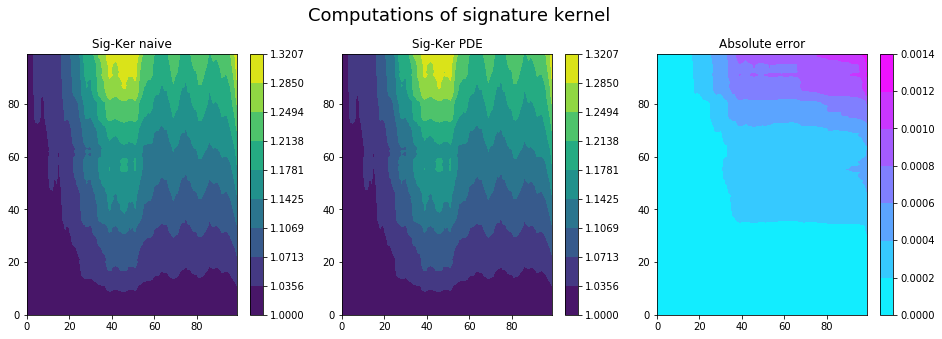

In [16]:
colorbar_range = np.linspace(min(K_naive.min(), K_PDE.min()), max(K_naive.max(), K_PDE.max()), 10).tolist()

fig, ax = plt.subplots(1, 3, figsize=(16,5))

ax1 = ax[0].contourf(K_naive, colorbar_range)
ax2 = ax[1].contourf(K_PDE, colorbar_range)
ax3 = ax[2].contourf(np.abs(K_naive-K_PDE), cmap='cool')

fig.colorbar(ax1, ax=ax[0])
fig.colorbar(ax2, ax=ax[1])
fig.colorbar(ax3, ax=ax[2])

ax[0].set_title('Sig-Ker naive', fontsize=12)
ax[1].set_title('Sig-Ker PDE', fontsize=12)
ax[2].set_title('Absolute error', fontsize=12)

plt.suptitle('Computations of signature kernel', fontsize=18)
plt.subplots_adjust(top=0.85)
plt.savefig('pictures/countour.png')
plt.show()

# Dependence on number of observations

In [23]:
t_naive = []
t_trunc = []
t_pde = []

lengths = range(10,100,5)
depth = 5

for M in tqdm(lengths):
    
    X, Y = generate(M,M)
    
    t = time.time()
    K_naive = np.ones((M,M))
    for i in range(1, M):
        for j in range(1, M):
            K_naive[i,j] = naive_SigKernel_iisig(X[:i+1], Y[:j+1], depth)
    t_naive.append(time.time()-t)
    
    t = time.time()
    K_trunc = truncated_sigKernel(np.array([X,Y]), depth)
    t_trunc.append(time.time()-t)
    
    t = time.time()
    K_PDE = sig_kernel(X,Y,n=1)
    t_pde.append(time.time()-t)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:22<00:00,  2.67s/it]


# Dependence on dimension

In [24]:
t_naive_dim = []
t_trunc_dim = []
t_pde_dim = []

M = 20
dims = range(100, 5000, 50)
depth = 3

for dim in tqdm(dims):
    
    # generate d-dim BM
    X,Y = generate(M, M, BM=True, dim_BM=dim)
    
#     t = time.time()
#     K_naive = np.ones((M,M))
#     for i in range(1, M):
#         for j in range(1, M):
#             K_naive[i,j] = naive_SigKernel_iisig(X[:i+1], Y[:j+1], depth)
#     t_naive_dim.append(time.time()-t)
    
    t = time.time()
    K_trunc = truncated_sigKernel(np.array([X,Y]), depth)
    t_trunc_dim.append(time.time()-t)
    
    t = time.time()
    K_PDE = sig_kernel(X,Y,n=0)
    t_pde_dim.append(time.time()-t)

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 24.07it/s]


# Visualization of results

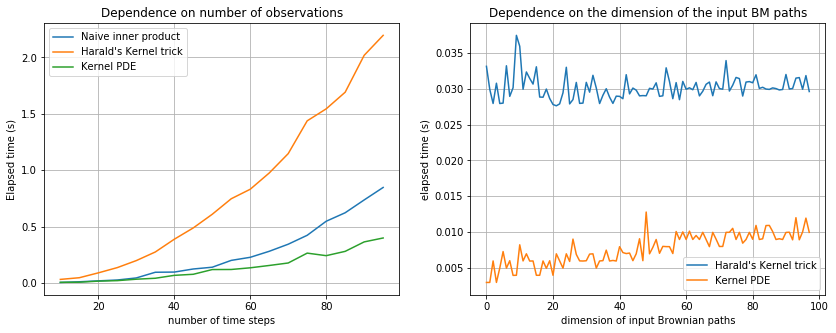

In [25]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

ax=plt.subplot(1, 2, 1)
ax.plot(lengths, t_naive, label='Naive inner product')
ax.plot(lengths, t_trunc, label="Harald's Kernel trick")
ax.plot(lengths, t_pde, label='Kernel PDE')
ax.set_title('Dependence on number of observations')
ax.set_xlabel('number of time steps')
ax.set_ylabel('Elapsed time (s)')
ax.legend()
ax.grid(True)

ax=plt.subplot(1, 2, 2)
# ax.plot(t_naive_dim, label='Naive inner product')
ax.plot(t_trunc_dim, label="Harald's Kernel trick")
ax.plot(t_pde_dim, label='Kernel PDE')
ax.set_title('Dependence on the dimension of the input BM paths')
ax.set_xlabel('dimension of input Brownian paths')
ax.set_ylabel('elapsed time (s)')
ax.legend()
ax.grid(True)


plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig('pictures/perfomance.png')
plt.show()